In [72]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [73]:
distribution_m = (4,1.2)
distribution_noise = (3,1.1)
distribution_experiment_noise = (0,1)
n_subjects = 20 # subjects
n_trials = int(100) # number of trials per subject
responses = (0.5,2)

In [74]:
results = {}
labels = {}
for n in range(n_subjects):
    # for each trial, there is internel noise contributes to the response
    internal_noise = np.random.normal(loc=distribution_noise[0],scale=distribution_noise[1],size=n_trials)
    # for each trial, there is a "m" drew from a N(4,1.2) distribution
    internal_m = np.random.normal(loc=distribution_m[0],scale=distribution_m[1],size=n_trials)
    # subject responses is a binomial distribution
    subject_responses = np.random.choice([-1,1],size=n_trials,p=[responses[0],responses[0]])
    # there exists some fixed experimental noise for all the subjects drew from a unit normal distribution
    noise = np.random.normal(loc=distribution_experiment_noise[0],scale=distribution_experiment_noise[1],size=n_trials)
    # since the formula: mx + b = y, where x is the measure, b is the internal noise, and y is the response,
    # the inverted measure simulation is: (y - b) / m + experimental noise
    measures = (subject_responses - internal_noise)/internal_m + noise
    results[n] = measures
    labels[n] = subject_responses

# fit a model for each subject and then plot the scores of them

In [75]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

In [76]:
result_scores = []
for n in range(n_subjects):
    model = linear_model.LogisticRegression(class_weight='balanced',random_state=12345,max_iter=int(1e5))
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
    scores = cross_val_score(model,results[n].reshape(-1,1),labels[n],cv=cv,scoring='roc_auc',)
    result_scores.append(scores)
result_scores = np.array(result_scores)
result_scores = pd.DataFrame(np.array([result_scores.flatten(),np.repeat(np.arange(n_subjects),5)]).T,
                            columns=['scores','subjects'])
result_scores['subjects'] = result_scores['subjects'].astype(int)

In [77]:
result_scores.groupby(['subjects']).describe()

scores                                                              \
          count      mean       std       min       25%       50%       75%   
subjects                                                                      
0           5.0  0.676515  0.118399  0.525253  0.611111  0.666667  0.750000   
1           5.0  0.713152  0.208162  0.466667  0.509091  0.820000  0.870000   
2           5.0  0.673071  0.063898  0.570000  0.670000  0.690000  0.690909   
3           5.0  0.664000  0.130499  0.510000  0.580000  0.640000  0.760000   
4           5.0  0.599596  0.065845  0.518182  0.555556  0.609091  0.626263   
5           5.0  0.737374  0.129946  0.575758  0.666667  0.717172  0.818182   
6           5.0  0.747677  0.085084  0.616162  0.722222  0.763636  0.797980   
7           5.0  0.748000  0.103537  0.600000  0.680000  0.800000  0.820000   
8           5.0  0.703232  0.114586  0.566667  0.627273  0.718182  0.737374   
9           5.0  0.686000  0.157734  0.500000  0.540000  0.730000  0.820000   
10          5.0  0.670283  0.106218  0.510000  0.633333  0.681818  0.744444   
11          5.0  0.617596  0.037270  0.572727  0.590000  0.622222  0.636364   
12          5.0  0.636364  0.051505  0.575758  0.606061  0.626263  0.666667   
13          5.0  0.674000  0.128569  0.460000  0.650000  0.730000  0.760000   
14          5.0  0.620626  0.167238  0.390909  0.540000  0.620000  0.730000   
15          5.0  0.597131  0.127902  0.470000  0.511111  0.560000  0.654545   
16          5.0  0.682660  0.102443  0.613636  0.626263  0.636364  0.675926   
17          5.0  0.644444  0.130025  0.494949  0.585859  0.606061  0.696970   
18          5.0  0.656768  0.074359  0.545455  0.622222  0.688889  0.690909   
19          5.0  0.610417  0.079876  0.468750  0.635417  0.635417  0.656250   

                    
               max  
subjects            
0         0.829545  
1         0.900000  
2         0.744444  
3         0.830000  
4         0.688889  
5         0.909091  
6         0.838384  
7         0.840000  
8         0.866667  
9         0.840000  
10        0.781818  
11        0.666667  
12        0.707071  
13        0.770000  
14        0.822222  
15        0.790000  
16        0.861111  
17        0.838384  
18        0.736364  
19        0.656250

Text(0.5,1,'grand average AUC = 0.67')

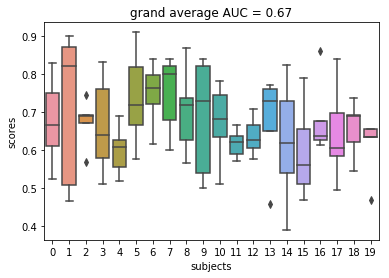

In [78]:
sns.boxplot(x='subjects',y='scores',data=result_scores)
plt.title('grand average AUC = %.2f'%(result_scores['scores'].mean()))

As we see from above, most of the subjects have a average AUC score above chance. Each subject has 5 model scores, which represent our estimate of the model mx + b = y. Thus, the grand average AUC (0.67) is how much the between-subject variability we estimate from the current simulated experiment.

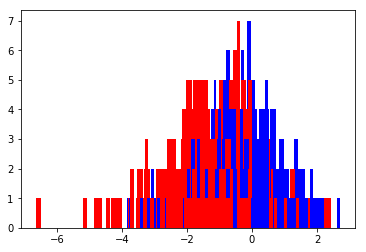

In [79]:
for (_,k),(_,l) in zip(results.items(),labels.items()): 
    idx_positive = l == 1
    idx_negative = l == -1
    plt.hist(k[idx_positive],color='blue',bins=50)
    plt.hist(k[idx_negative],color='red',bins=50)

As shown above, it the two distributions of measures for the positive responses (blue) and the negative responses (red). They overlap a lot, which suggests low signal-to-noise ratio for the data as a whole.

# average measures within each subject and fit a model for the averaged data

In [80]:
data = []
for (_,k),(_,l) in zip(results.items(),labels.items()):
    idx_positive = l == 1
    idx_negative = l == -1
    data.append([k[idx_positive].mean(),1])
    data.append([k[idx_negative].mean(),-1])
data = np.array(data)

In [81]:
model = linear_model.LogisticRegression(class_weight='balanced',random_state=12345,max_iter=int(1e5))
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
scores = cross_val_score(model,data[:,0].reshape(-1,1),data[:,1],cv=cv,scoring='roc_auc',)
print(scores)

[1. 1. 1. 1. 1.]


We have a perfect score when we use the averaged measures

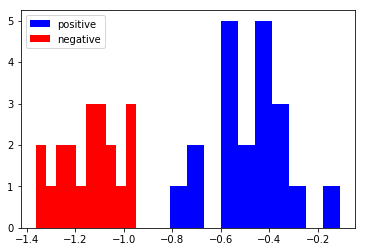

In [82]:
plt.hist(data[data[:,1]==1,0],color='blue',label='positive')
plt.hist(data[data[:,1]==-1,0],color='red',label='negative')
plt.legend()

As shown above, after we average the measure within each subject, we do have better representation (signal) of the data distribution. There is a clear boundary between positive and negative responses. 